In [6]:
!pip install bert-for-tf2
!pip install tensorflow-text
!pip install tqdm

!pip install flask-ngrok
!pip install flask==0.12.2 
!pip install -U flask-cors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2022-08-28 17:52:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  31.3MB/s    in 0.4s    

2022-08-28 17:52:01 (31.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.callbacks import EarlyStopping

import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense

from flask import Flask
from flask_ngrok import run_with_ngrok
import numpy as np
from flask import Flask, request
from flask_cors import CORS
from keras.models import load_model
from PIL import Image, ImageOps
import json

import warnings
warnings.filterwarnings('always')

In [9]:
SAdata = pd.read_excel("/content/news.xlsx")
SAdata = SAdata.iloc[:, 1:]
NERdata = pd.read_excel("/content/NER.xlsx")

In [10]:
SAdata.head()

,Headlines,Sentiment
0,மோதி சர்ச்சை - பார்த்திபன் விளக்கம்: “மோடிஜீக்...,-1
1,ஒடிசா மில்லட்ஸ் மிஷன்.. பாரம்பரிய உணவு பயிர்கள...,1
2,கோட்டாயபய ராஜபக்ஷ தாய்லாந்துக்குச் செல்லத் திட...,0
3,இலங்கையில் அடுத்த நெருக்கடி: மின் கட்டணம் 75% ...,-1
4,"""சாமி"" யார்னு தெரியுதா.. அதே மிர்ச்சி பாபாதான்...",-1


In [11]:
NERdata.head()

,Data,NER
0,வா,O
1,போ,O
2,நில்,O
3,சாப்பாடு,O
4,துணி,O


## Train Test Split

In [12]:
SAencoder = OneHotEncoder(handle_unknown='ignore')
SAencoder_df = pd.DataFrame(SAencoder.fit_transform(SAdata[['Sentiment']]).toarray())

NERencoder = OneHotEncoder(handle_unknown='ignore')
NERencoder_df = pd.DataFrame(NERencoder.fit_transform(NERdata[['NER']]).toarray())

In [13]:
SA_X = SAdata["Headlines"].values
SA_Y = SAencoder_df

NER_X = NERdata["Data"].values
NER_Y = NERencoder_df

SA_X_train, SA_X_test , SA_y_train, SA_y_test = train_test_split(SA_X, SA_Y, test_size=0.2)
NER_X_train, NER_X_test , NER_y_train, NER_y_test = train_test_split(NER_X, NER_Y, test_size=0.2)

In [14]:
print("Training X Dim ",SA_X_train.shape)
print("Training y Dim ",SA_y_train.shape)

print("Training X Dim ",NER_X_train.shape)
print("Training y Dim ",NER_y_train.shape)

Training X Dim  (1200,)
Training y Dim  (1200, 3)
Training X Dim  (11634,)
Training y Dim  (11634, 14)


# MURIL

In [15]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer("https://tfhub.dev/google/MuRIL_preprocess/1")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer("https://tfhub.dev/google/MuRIL/1", trainable=False)
outputs = encoder(encoder_inputs)

pooled_output = outputs["pooled_output"] 
sequence_output = outputs["sequence_output"] 

muril_model = tf.keras.Model(text_input, pooled_output)
# muril_model.save("Muril.h5")
# muril_model = keras.models.load_model('./Muril.h5', custom_objects={ 'KerasLayer': hub.KerasLayer})

In [16]:
muril_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## Create Embeddings using MuRIL

In [17]:
def get_embeddings(X, muril_model, batch_size):
    rows = X.shape[0]

    embeddings = muril_model(X[:batch_size])

    for i in tqdm(range(batch_size, rows, batch_size)):
        embed_curr = muril_model(X[i : i+batch_size])
        embeddings = np.concatenate((embeddings, embed_curr))

    return np.array(embeddings)

In [18]:
SA_X_train_embeds = get_embeddings(SA_X_train, muril_model, 128)
SA_X_test_embeds = get_embeddings(SA_X_test, muril_model, 128)

100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


In [19]:
NER_X_train_embeds = get_embeddings(NER_X_train, muril_model, 128)
NER_X_test_embeds = get_embeddings(NER_X_test, muril_model, 128)

100%|██████████| 22/22 [00:35<00:00,  1.61s/it]


In [20]:
print(SA_X_train_embeds.shape)
print(SA_X_test_embeds.shape)
print(NER_X_train_embeds.shape)
print(NER_X_test_embeds.shape)

(1200, 768)
(301, 768)
(11634, 768)
(2909, 768)


# Scaling

In [21]:
SA_scaler = StandardScaler()

SA_X_train_embeds_sc = SA_scaler.fit_transform(SA_X_train_embeds)
SA_X_test_embeds_sc = SA_scaler.transform(SA_X_test_embeds)

NER_scaler = StandardScaler()

NER_X_train_embeds_sc = NER_scaler.fit_transform(NER_X_train_embeds)
NER_X_test_embeds_sc = NER_scaler.transform(NER_X_test_embeds)

# SA Model using Embeddings

In [22]:
SA_model = Sequential()

SA_model.add(Dense(units=768, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=1024, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=1024, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=512, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=256, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=128, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=32, activation='relu'))
SA_model.add(Dropout(0.3))
SA_model.add(Dense(units=3, activation='softmax'))

In [23]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2,verbose=1)
SA_model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics=["accuracy"])

In [24]:
batch_size = 256
epochs = 20

SA_history = SA_model.fit(SA_X_train_embeds_sc, SA_y_train, batch_size=batch_size, epochs = epochs, shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 6ms/step - loss: 0.9693 - accuracy: 0.6292
Epoch 2/20
5/5 [==============================] - 0s 5ms/step - loss: 0.8194 - accuracy: 0.6808
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.7509 - accuracy: 0.7083
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.7217
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.7158
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.7592
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.5670 - accuracy: 0.7608
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 0.5199 - accuracy: 0.7908
Epoch 9/20
5/5 [==============================] - 0s 6ms/step - loss: 0.4730 - accuracy: 0.8142
Epoch 10/20
5/5 [==============================] - 0s 6ms/step - loss: 0.3982 - accuracy: 0.8483
Epoch 11/20
5/5 [======================

In [25]:
SA_model.evaluate(x=SA_X_test_embeds_sc, y=SA_y_test)

10/10 [==============================] - 0s 4ms/step - loss: 1.2779 - accuracy: 0.7010


[1.2778788805007935, 0.7009966969490051]

In [26]:
SA_model.save('./SAmodel.h5')
model = keras.models.load_model('./SAmodel.h5')

# NER model using Embeddings

In [27]:
NER_model = Sequential()

NER_model.add(Dense(units=768, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=1024, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=1024, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=512, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=256, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=128, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=32, activation='relu'))
NER_model.add(Dropout(0.3))
NER_model.add(Dense(units=14, activation='softmax'))

In [28]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2,verbose=1)
NER_model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics=["accuracy"])

In [29]:
batch_size = 256
epochs = 80

NER_history = NER_model.fit(NER_X_train_embeds_sc, NER_y_train, batch_size=batch_size, epochs = epochs, shuffle=True)

Epoch 1/80
46/46 [==============================] - 1s 6ms/step - loss: 0.4491 - accuracy: 0.9232
Epoch 2/80
46/46 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.9574
Epoch 3/80
46/46 [==============================] - 0s 5ms/step - loss: 0.1573 - accuracy: 0.9587
Epoch 4/80
46/46 [==============================] - 0s 5ms/step - loss: 0.1260 - accuracy: 0.9672
Epoch 5/80
46/46 [==============================] - 0s 5ms/step - loss: 0.1077 - accuracy: 0.9738
Epoch 6/80
46/46 [==============================] - 0s 5ms/step - loss: 0.0971 - accuracy: 0.9755
Epoch 7/80
46/46 [==============================] - 0s 5ms/step - loss: 0.0884 - accuracy: 0.9765
Epoch 8/80
46/46 [==============================] - 0s 5ms/step - loss: 0.0760 - accuracy: 0.9777
Epoch 9/80
46/46 [==============================] - 0s 5ms/step - loss: 0.0856 - accuracy: 0.9774
Epoch 10/80
46/46 [==============================] - 0s 5ms/step - loss: 0.0740 - accuracy: 0.9782
Epoch 11/80
46/46 [

## Training History

In [30]:
print("SA confusion Matrix")
predict_x=SA_model.predict(SA_X_test_embeds_sc)
SA_classes_x=np.argmax(predict_x,axis=1)
SA_classes_y=np.argmax(SA_y_test.to_numpy(), axis = 1)
print(classification_report(SA_classes_y, SA_classes_x))

SA confusion Matrix
10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.52      0.54        75
           1       0.79      0.81      0.80       211
           2       0.07      0.07      0.07        15

    accuracy                           0.70       301
   macro avg       0.47      0.47      0.47       301
weighted avg       0.70      0.70      0.70       301



In [31]:
print("NER confusion Matrix")
predict_x=NER_model.predict(NER_X_test_embeds_sc)
NER_classes_x=np.argmax(predict_x,axis=1)
NER_classes_y=np.argmax(NER_y_test.to_numpy(), axis = 1)
print(classification_report(NER_classes_y, NER_classes_x))

NER confusion Matrix
91/91 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.50      0.36      0.42        11
           3       0.53      0.38      0.44        21
           4       0.83      0.66      0.74        74
           5       0.47      0.47      0.47        17
           7       0.00      0.00      0.00         1
           8       0.98      0.99      0.99      2777
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3

    accuracy                           0.97      2909
   macro avg       0.30      0.26      0.28      2909
weighted avg       0.97      0.97      0.97      2909



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SA Heat Map


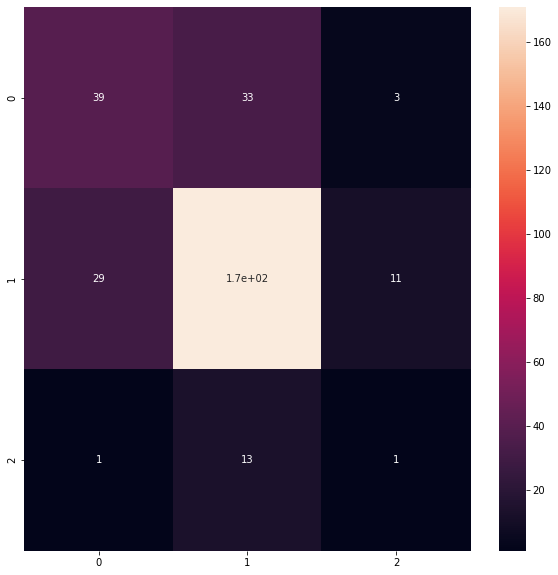

In [32]:
print("SA Heat Map")
plt.figure(figsize=(10,10))
mat = confusion_matrix(SA_classes_y, SA_classes_x)
sns.heatmap(mat, annot=True)
plt.show()

NER Heat Map


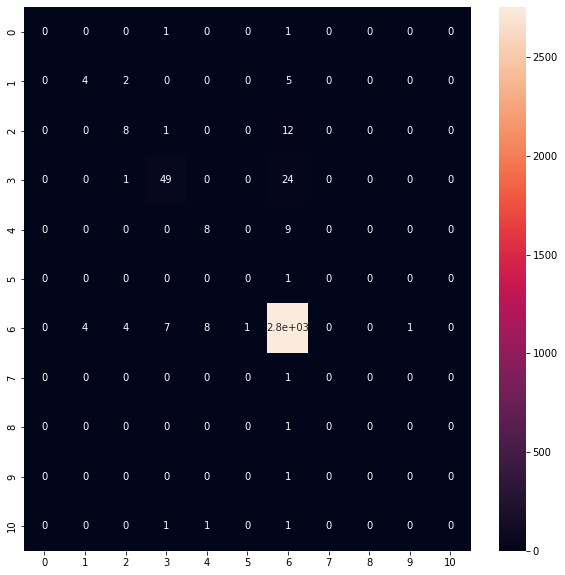

In [33]:
print("NER Heat Map")
plt.figure(figsize=(10,10))
mat = confusion_matrix(NER_classes_y, NER_classes_x)
sns.heatmap(mat, annot=True)
plt.show()

###Flask app

In [34]:
def get_SA(input):
  test = get_embeddings(np.array([input], dtype = "object"), muril_model, 128)
  clas = np.argmax(SA_model.predict(SA_scaler.transform(test)))
  prediction = ""
  if (clas == 0):
    prediction = "Negative"
  elif (clas == 2):
    prediction = "Positive"
  else:
    prediction = "Neutral"
  return prediction

In [35]:
def get_NER(input):
  tags = {0:'B-art',1:'B-eve',2:'B-geo',3:'B-gpe',4:'B-per',5:'B-tim',6:'I-art',7:'I-per',8:'O',9:'O-art',10:'O-geo',11:'O-gpe',12:'O-per',13:'O-tim'}
  words = input.split()
  words
  output = " ,"
  for word in words:
    test = get_embeddings(np.array([word], dtype = "object"), muril_model, 128)
    clas = np.argmax(NER_model.predict(NER_scaler.transform(test), verbose = 0))
    if(tags[clas] != 'O'):
      output += word+" - "+tags[clas]+" , "
  return output[:-2]

#Flask app

In [36]:
!/ngrok authtoken 2Dr6OYX7L5tIkxTmHFsr51MGvzd_33L4gdM7TJSuwTyYUQqcF

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [37]:
app = Flask(__name__)
CORS(app)
run_with_ngrok(app) 

@app.route('/submit', methods=['POST'])
def submit():
    
    # x = {"message": request.form["text"]}
    inp = request.form["text"]
    x = {"message": get_SA(inp)+get_NER(inp)}
    y = json.dumps(x)
    return y

@app.route('/feedback', methods=['POST'])
def feedback():
    # NERdata.loc[len(NERdata.index)] = [request.form["text"], prediction] 
    # NER_model.fit(NER_X_train_embeds_sc, NER_y_train, batch_size=batch_size, epochs = epochs, shuffle=True)
    inp = request.form["Feedback"]
    x = {"message": True}
    y = json.dumps(x)
    return y

In [38]:
app.run()

INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fee5-34-69-57-154.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f5950afc520>
0it [00:00, ?it/s]

1/1 [==============================] - 0s 16ms/step



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
INFO:werkzeug:127.0.0.1 - - [28/Aug/2022 18:00:11] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Aug/2022 18:01:52] "POST /feedback HTTP/1.1" 200 -
